**DATASET UPLOAD**


In [ ]:
# ====== Setup Cell ======
# Install extra libraries (only needed once)
!pip install scikit-image seaborn matplotlib

# Mount Google Drive (uncomment if dataset is in Drive)
#from google.colab import drive
#drive.mount('/content/drive')

# Upload dataset zip file (if not using Drive)
from google.colab import files
uploaded = files.upload()

# If uploaded, unzip it (adjust filename if needed)
!unzip dataset.zip -d dataset

print("✅ Setup complete.")

Saving dataset_split.zip to dataset_split.zip
unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.
✅ Setup complete. Now run Block 1 (LBP Feature Extraction).


In [ ]:
import os

# List all files in current directory
print(os.listdir())

# Pick the correct zip file name from the list

['.config', 'dataset_split.zip', 'sample_data']


In [ ]:
import zipfile
import os

zip_path = "dataset_split.zip"  # use the correct file

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

# Check folder structure
print(os.listdir("dataset_split"))

['train', 'test']


**PREPROCESSING - RESIZING IMAGES TO 224X224, NORMALIZATION**

In [ ]:
# _____________________________ CNN PREPROCESSING _____________________________
import os
import cv2
import numpy as np

# -------------------------------
# CONFIG
# -------------------------------
DATASET_DIR = "dataset_split"  # Your dataset root folder
IMG_SIZE = (224, 224)          # CNN models expect 224x224 RGB images

def preprocess_cnn_images(folder, class_names):
    images, labels, paths = [], [], []
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            img = cv2.imread(img_path)  # Loads as BGR
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, IMG_SIZE)             # Resize to 224x224
            img = img.astype("float32") / 255.0         # Normalize [0, 1]

            images.append(img)
            labels.append(label)
            paths.append(img_path)

    return np.array(images), np.array(labels), paths

# -------------------------------
# MAIN
# -------------------------------
train_dir = os.path.join(DATASET_DIR, "train")
test_dir = os.path.join(DATASET_DIR, "test")

class_names = sorted(os.listdir(train_dir))

# Preprocess train & test
X_train, y_train, train_paths = preprocess_cnn_images(train_dir, class_names)
X_test, y_test, test_paths = preprocess_cnn_images(test_dir, class_names)

# Save resized data
np.savez_compressed("cnn_preprocessed_dataset.npz",
                    X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test,
                    train_paths=train_paths, test_paths=test_paths,
                    class_names=class_names)

print("✅ CNN Preprocessing complete")
print("Train set:", X_train.shape, y_train.shape)
print("Test set :", X_test.shape, y_test.shape)
print("Classes  :", class_names)


✅ CNN Preprocessing complete
Train set: (2049, 224, 224, 3) (2049,)
Test set : (515, 224, 224, 3) (515,)
Classes  : ['African elephant', 'Egyptian cat', 'German shepherd', 'Labrador retriever', 'dragonfly', 'golden retriever', 'gorilla', 'koala', 'monarch', 'peacock', 'rose', 'sports car']


**VISUALIZATION OF ORIGINAL IMAGE Vs PREPROCESSED IMAGE**


Loaded preprocessed data ✅
Train: (2049, 224, 224, 3) (2049,)
Classes: ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']


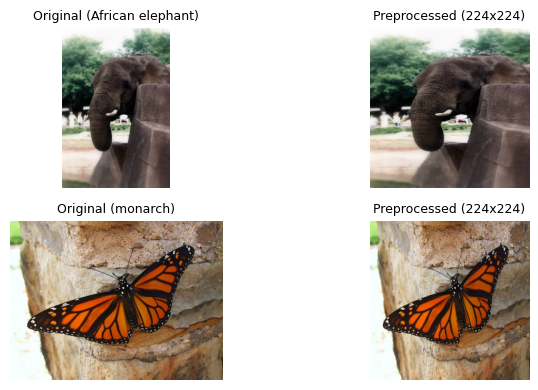

In [ ]:
# _____________________________ VISUALIZATION OF PREPROCESSED DATA _____________________________
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# -------------------------------
# LOAD PREPROCESSED DATA
# -------------------------------
data = np.load("cnn_preprocessed_dataset.npz", allow_pickle=True)

X_train, y_train = data["X_train"], data["y_train"]
train_paths = data["train_paths"]
class_names = data["class_names"]

print("Loaded preprocessed data ✅")
print("Train:", X_train.shape, y_train.shape)
print("Classes:", class_names)

# -------------------------------
# VISUALIZATION (2 Random Samples)
# -------------------------------
plt.figure(figsize=(8, 4))

for i in range(2):
    idx = random.randint(0, len(train_paths) - 1)

    # Load original image
    orig = cv2.imread(train_paths[idx])
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Get preprocessed image (convert back to 0-255 for display)
    preprocessed = (X_train[idx] * 255).astype("uint8")

    plt.subplot(2, 2, i*2 + 1)
    plt.imshow(orig)
    plt.title(f"Original ({class_names[y_train[idx]]})", fontsize=9)
    plt.axis("off")

    plt.subplot(2, 2, i*2 + 2)
    plt.imshow(preprocessed)
    plt.title("Preprocessed (224x224)", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


**EXTRACTION OF FEATURES USING VGG16 & RESNET50**

In [ ]:
# _____________________________ FEATURE EXTRACTION: VGG16 + RESNET50 (SAVE RAW + FLATTENED) _____________________________
import numpy as np
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model

# -------------------------------
# LOAD PREPROCESSED DATA
# -------------------------------
data = np.load("cnn_preprocessed_dataset.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
class_names = data["class_names"]

print("✅ Loaded CNN preprocessed data")
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

# -------------------------------
# FEATURE EXTRACTION FUNCTION
# -------------------------------
def extract_features(base_model, model_name):
    print(f"\n🔎 Extracting features using {model_name}...")
    feature_model = Model(inputs=base_model.input, outputs=base_model.output)

    # Get raw feature maps
    train_features_raw = feature_model.predict(X_train, batch_size=32, verbose=1)
    test_features_raw = feature_model.predict(X_test, batch_size=32, verbose=1)

    # Flatten features for training
    train_features_flat = train_features_raw.reshape(train_features_raw.shape[0], -1)
    test_features_flat = test_features_raw.reshape(test_features_raw.shape[0], -1)

    print(f"{model_name} features extracted:")
    print("Train features:", train_features_flat.shape)
    print("Test features :", test_features_flat.shape)

    return train_features_raw, test_features_raw, train_features_flat, test_features_flat

# -------------------------------
# VGG16 FEATURE EXTRACTION
# -------------------------------
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
X_train_vgg_raw, X_test_vgg_raw, X_train_vgg, X_test_vgg = extract_features(vgg16_base, "VGG16")

# -------------------------------
# RESNET50 FEATURE EXTRACTION
# -------------------------------
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
X_train_resnet_raw, X_test_resnet_raw, X_train_resnet, X_test_resnet = extract_features(resnet50_base, "ResNet50")

# -------------------------------
# SAVE BOTH FEATURE SETS
# -------------------------------
np.savez_compressed("cnn_features_vgg16_resnet50.npz",
                    # Flattened (for classifiers)
                    X_train_vgg=X_train_vgg, X_test_vgg=X_test_vgg,
                    X_train_resnet=X_train_resnet, X_test_resnet=X_test_resnet,
                    # Raw (for visualization)
                    X_train_vgg_raw=X_train_vgg_raw, X_test_vgg_raw=X_test_vgg_raw,
                    X_train_resnet_raw=X_train_resnet_raw, X_test_resnet_raw=X_test_resnet_raw,
                    y_train=y_train, y_test=y_test,
                    class_names=class_names)

print("\n✅ Feature extraction complete and saved (both raw & flattened)")


✅ Loaded CNN preprocessed data
Train: (2049, 224, 224, 3) (2049,)
Test : (515, 224, 224, 3) (515,)

🔎 Extracting features using VGG16...
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step
VGG16 features extracted:
Train features: (2049, 25088)
Test features : (515, 25088)

🔎 Extracting features using ResNet50...
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
ResNet50 features extracted:
Train features: (2049, 100352)
Test features : (515, 100352)

✅ Feature extraction complete and saved (both raw & flattened)


**VISUALIZATION OF FEATURE MAPS OF VGG16 & RESNET50**

✅ Loaded preprocessed data & raw feature maps


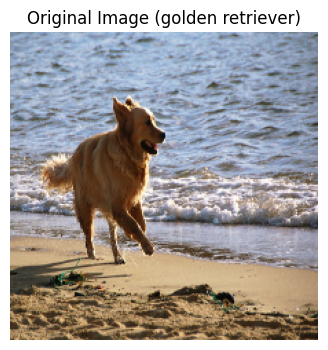

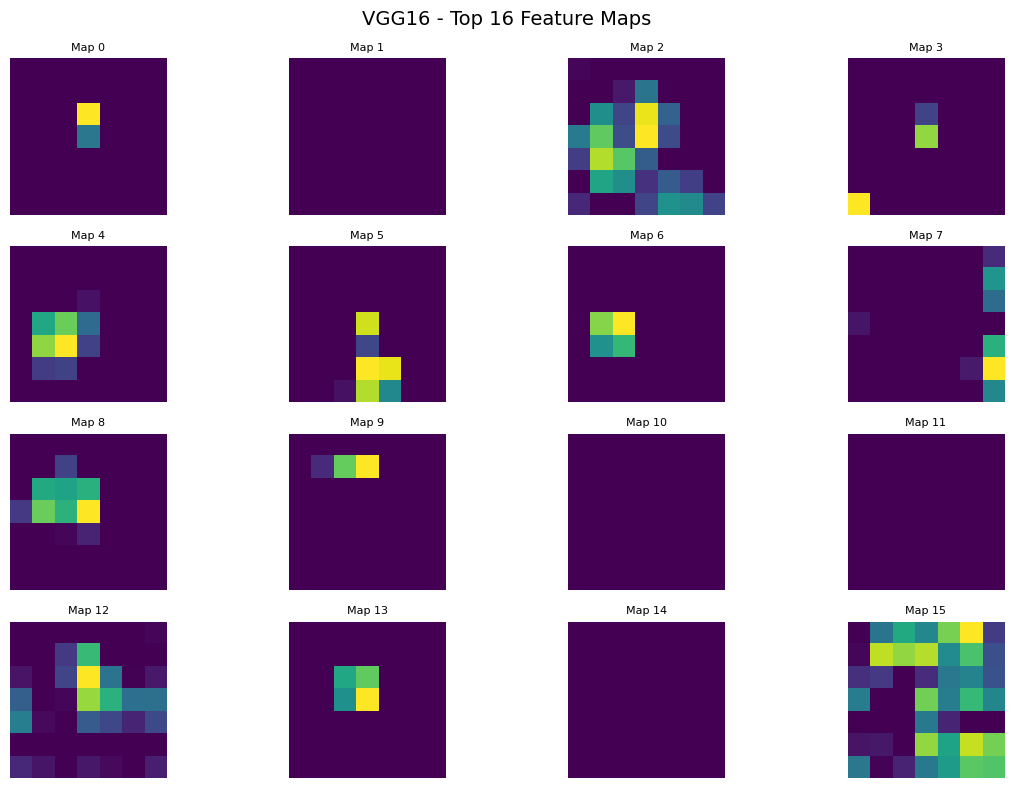

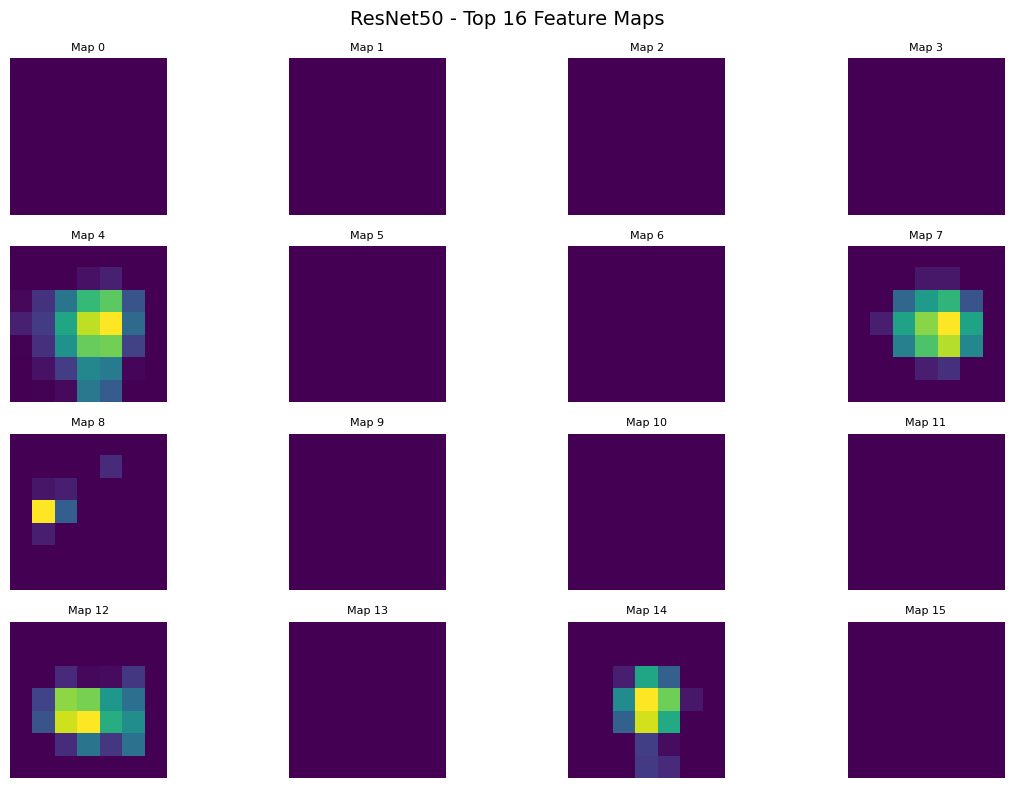

In [ ]:
# _____________________________ VISUALIZE CNN FEATURES: FULL GRID _____________________________
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# LOAD DATA
# -------------------------------
data_pre = np.load("cnn_preprocessed_dataset.npz", allow_pickle=True)
X_train_pre, y_train = data_pre["X_train"], data_pre["y_train"]
class_names = data_pre["class_names"]

data_feat = np.load("cnn_features_vgg16_resnet50.npz", allow_pickle=True)
X_train_vgg_raw = data_feat["X_train_vgg_raw"]        # (N, 7, 7, 512)
X_train_resnet_raw = data_feat["X_train_resnet_raw"]  # (N, 7, 7, 2048)

print("✅ Loaded preprocessed data & raw feature maps")

# -------------------------------
# FUNCTION TO PLOT FEATURE MAP GRID
# -------------------------------
def plot_feature_maps(feature_maps, model_name, num_maps=16):
    """
    feature_maps: (H, W, C) tensor
    model_name: string
    num_maps: number of channels to visualize
    """
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"{model_name} - Top {num_maps} Feature Maps", fontsize=14)

    for i in range(num_maps):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[:, :, i], cmap="viridis")
        plt.axis("off")
        plt.title(f"Map {i}", fontsize=8)

    plt.tight_layout()
    plt.show()

# -------------------------------
# VISUALIZATION FOR 1 SAMPLE
# -------------------------------
idx = np.random.randint(0, X_train_pre.shape[0])
label = class_names[y_train[idx]]

orig_img = (X_train_pre[idx] * 255).astype("uint8")
vgg_maps = X_train_vgg_raw[idx]
resnet_maps = X_train_resnet_raw[idx]

# Show original
plt.figure(figsize=(4, 4))
plt.imshow(orig_img)
plt.title(f"Original Image ({label})")
plt.axis("off")
plt.show()

# Show VGG16 Feature Map Grid
plot_feature_maps(vgg_maps, "VGG16", num_maps=16)

# Show ResNet50 Feature Map Grid
plot_feature_maps(resnet_maps, "ResNet50", num_maps=16)


**LOGISTIC REGRESSION CLASSIFIER ON 2 SETS OF FEATURES [VGG16 & RESNET50]**

✅ Loaded flattened CNN features
VGG16 Train: (2049, 25088) Test: (515, 25088)
ResNet50 Train: (2049, 100352) Test: (515, 100352)

🔎 Training Logistic Regression on VGG16 features...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



📊 Classification Report (VGG16)
                    precision    recall  f1-score   support

  African elephant       0.81      0.94      0.87        50
      Egyptian cat       0.91      0.62      0.74        16
   German shepherd       0.63      0.58      0.60        38
Labrador retriever       0.63      0.60      0.62        60
         dragonfly       0.93      0.93      0.93        54
  golden retriever       0.64      0.61      0.62        46
           gorilla       0.58      0.55      0.56        20
             koala       0.86      0.91      0.89        70
           monarch       0.93      0.93      0.93        68
           peacock       0.97      0.93      0.95        40
              rose       0.85      0.92      0.88        25
        sports car       0.93      1.00      0.97        28

          accuracy                           0.81       515
         macro avg       0.81      0.79      0.80       515
      weighted avg       0.81      0.81      0.81       515

✅ Ma

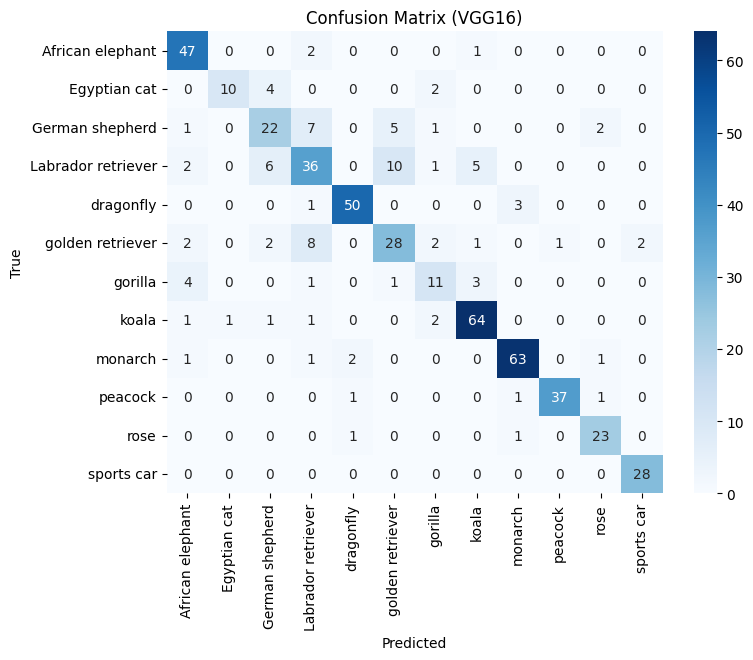

ROC-AUC Score (VGG16): 0.9736


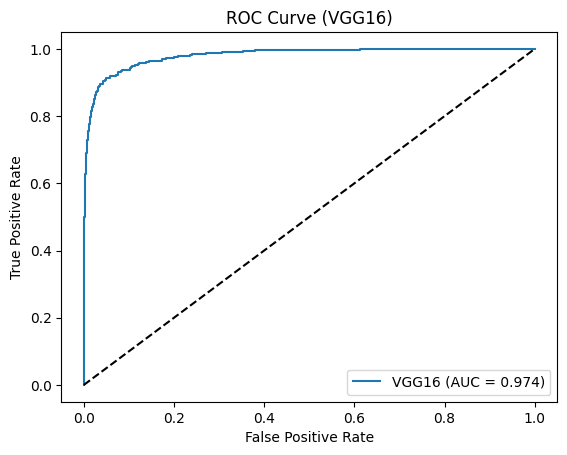


🔎 Training Logistic Regression on ResNet50 features...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



📊 Classification Report (ResNet50)
                    precision    recall  f1-score   support

  African elephant       0.61      0.66      0.63        50
      Egyptian cat       0.00      0.00      0.00        16
   German shepherd       0.30      0.32      0.31        38
Labrador retriever       0.35      0.40      0.38        60
         dragonfly       0.63      0.63      0.63        54
  golden retriever       0.27      0.33      0.30        46
           gorilla       0.31      0.25      0.28        20
             koala       0.53      0.60      0.56        70
           monarch       0.75      0.76      0.76        68
           peacock       0.76      0.65      0.70        40
              rose       0.60      0.24      0.34        25
        sports car       0.64      0.57      0.60        28

          accuracy                           0.51       515
         macro avg       0.48      0.45      0.46       515
      weighted avg       0.52      0.51      0.51       515

✅

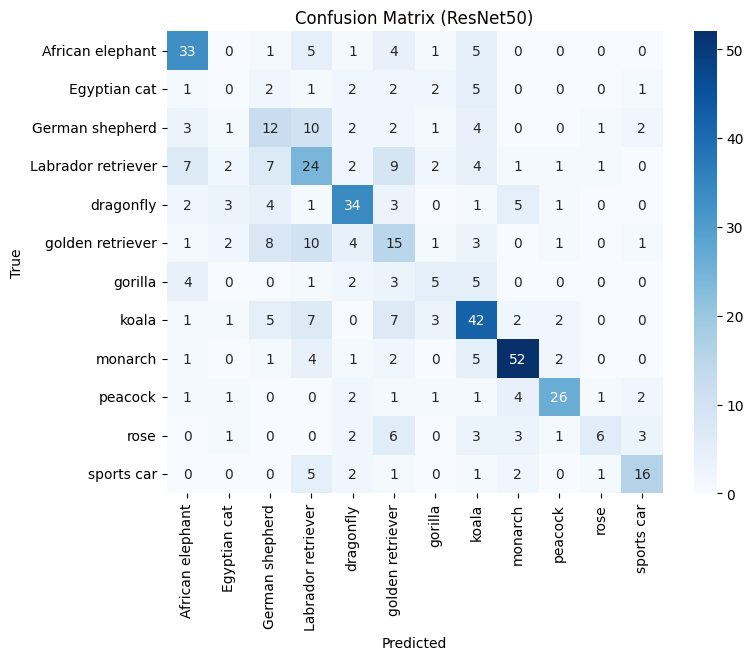

ROC-AUC Score (ResNet50): 0.8607


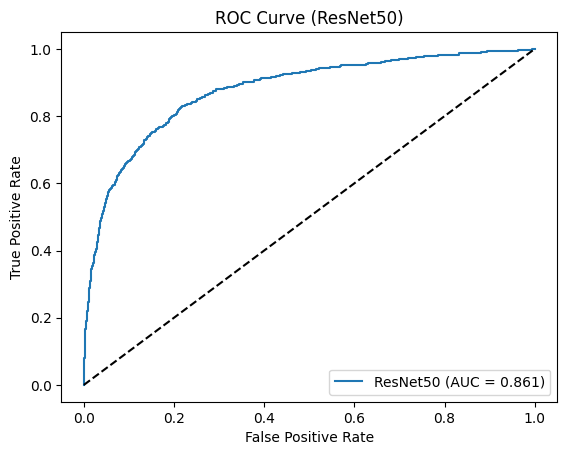

In [ ]:
# _____________________________ LOGISTIC REGRESSION CLASSIFIER _____________________________
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef,
    log_loss
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# LOAD FEATURES
# -------------------------------
data = np.load("cnn_features_vgg16_resnet50.npz", allow_pickle=True)

X_train_vgg, X_test_vgg = data["X_train_vgg"], data["X_test_vgg"]
X_train_resnet, X_test_resnet = data["X_train_resnet"], data["X_test_resnet"]
y_train, y_test = data["y_train"], data["y_test"]
class_names = data["class_names"]

print("✅ Loaded flattened CNN features")
print("VGG16 Train:", X_train_vgg.shape, "Test:", X_test_vgg.shape)
print("ResNet50 Train:", X_train_resnet.shape, "Test:", X_test_resnet.shape)

# -------------------------------
# FUNCTION: Train + Evaluate
# -------------------------------
def train_and_evaluate(X_train, X_test, y_train, y_test, model_name):
    print(f"\n🔎 Training Logistic Regression on {model_name} features...")

    # Train logistic regression
    clf = LogisticRegression(max_iter=300, solver="lbfgs", multi_class="ovr", n_jobs=-1)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)

    # -------------------------------
    # Classification Report
    # -------------------------------
    print(f"\n📊 Classification Report ({model_name})")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # -------------------------------
    # Additional Metrics (MCC + Log Loss)
    # -------------------------------
    mcc = matthews_corrcoef(y_test, y_pred)
    ll = log_loss(y_test, y_proba)
    print(f"✅ Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"✅ Log Loss: {ll:.4f}")

    # -------------------------------
    # Confusion Matrix
    # -------------------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()

    # -------------------------------
    # ROC-AUC (One-vs-Rest)
    # -------------------------------
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
    auc_score = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
    print(f"ROC-AUC Score ({model_name}): {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({model_name})")
    plt.legend(loc="lower right")
    plt.show()


# -------------------------------
# RUN FOR BOTH FEATURE SETS
# -------------------------------
train_and_evaluate(X_train_vgg, X_test_vgg, y_train, y_test, "VGG16")
train_and_evaluate(X_train_resnet, X_test_resnet, y_train, y_test, "ResNet50")


**KNN CLASSIFIER ON 2 SETS OF FEATURES [VGG16 & RESNET50]**

✅ Loaded CNN feature vectors
VGG16 Train shape : (2049, 25088)
ResNet Train shape: (2049, 100352)

🔎 Training KNN (VGG16) with k=5...

📊 Classification Report (VGG16):
                    precision    recall  f1-score   support

  African elephant       0.26      0.94      0.41        50
      Egyptian cat       0.00      0.00      0.00        16
   German shepherd       0.62      0.13      0.22        38
Labrador retriever       0.36      0.27      0.30        60
         dragonfly       0.75      0.67      0.71        54
  golden retriever       0.35      0.46      0.40        46
           gorilla       0.37      0.35      0.36        20
             koala       0.89      0.24      0.38        70
           monarch       0.85      0.74      0.79        68
           peacock       1.00      0.45      0.62        40
              rose       0.41      0.68      0.52        25
        sports car       1.00      0.64      0.78        28

          accuracy                           0.49 

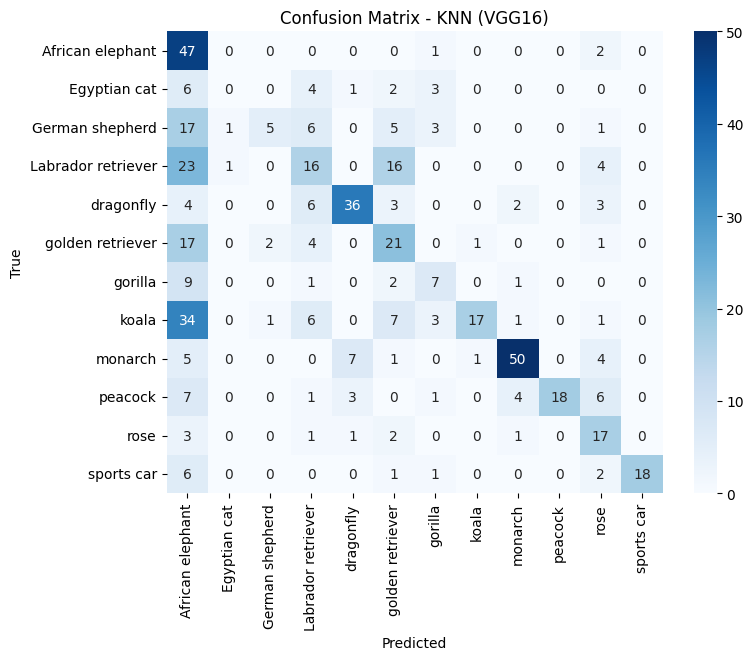

✅ Matthews Correlation Coefficient (MCC) [VGG16]: 0.4564
✅ Log Loss [VGG16]: 9.2134
ROC-AUC Score (macro, OVR) [VGG16]: 0.8201


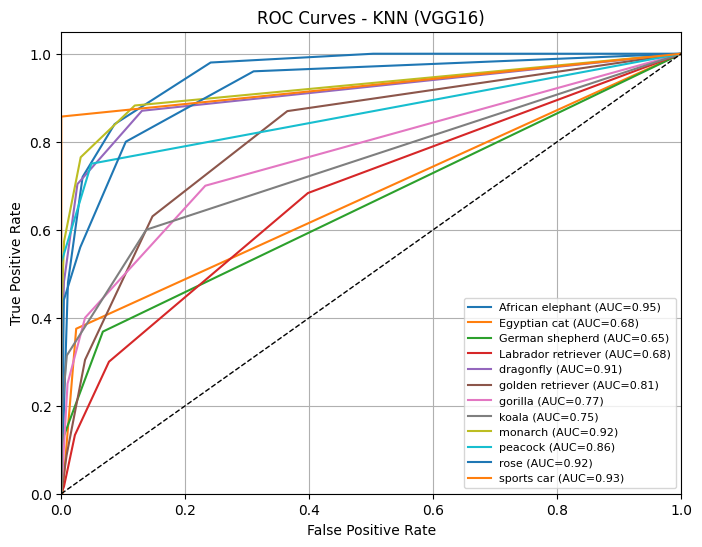


🔎 Training KNN (ResNet50) with k=5...

📊 Classification Report (ResNet50):
                    precision    recall  f1-score   support

  African elephant       0.42      0.62      0.50        50
      Egyptian cat       0.17      0.12      0.14        16
   German shepherd       0.24      0.32      0.27        38
Labrador retriever       0.19      0.22      0.20        60
         dragonfly       0.48      0.44      0.46        54
  golden retriever       0.21      0.26      0.23        46
           gorilla       0.20      0.15      0.17        20
             koala       0.52      0.40      0.45        70
           monarch       0.52      0.71      0.60        68
           peacock       0.59      0.42      0.49        40
              rose       0.10      0.04      0.06        25
        sports car       1.00      0.14      0.25        28

          accuracy                           0.38       515
         macro avg       0.39      0.32      0.32       515
      weighted avg    

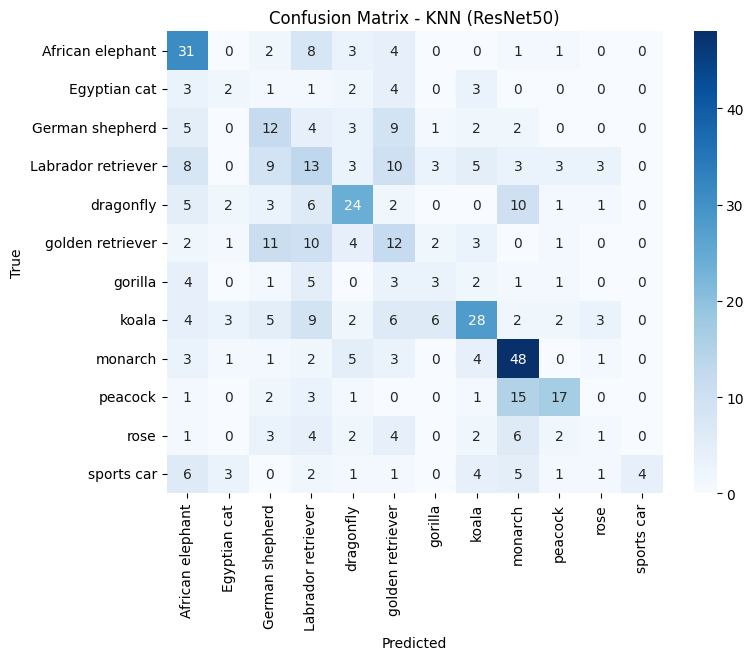

✅ Matthews Correlation Coefficient (MCC) [ResNet50]: 0.3098
✅ Log Loss [ResNet50]: 12.3142
ROC-AUC Score (macro, OVR) [ResNet50]: 0.7141


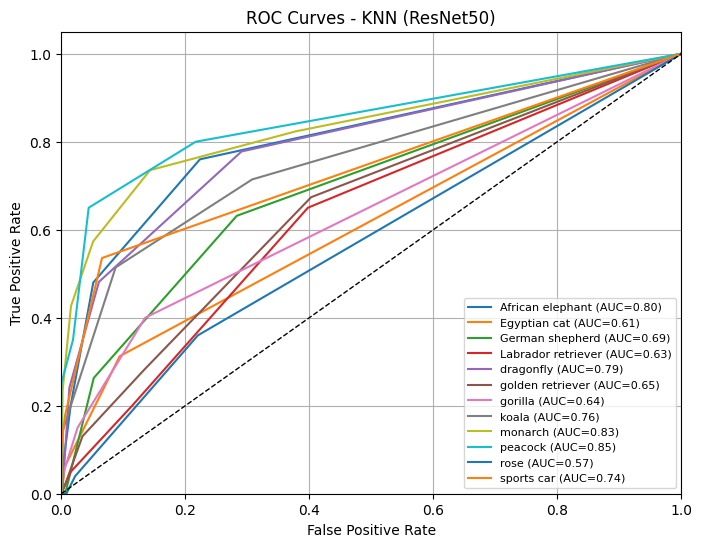

In [ ]:
# _____________________________ KNN CLASSIFIER (VGG16 + RESNET50 FEATURES) with MCC + LogLoss _____________________________
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
    matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# LOAD FEATURES
# -------------------------------
data = np.load("cnn_features_vgg16_resnet50.npz", allow_pickle=True)

X_train_vgg, X_test_vgg = data["X_train_vgg"], data["X_test_vgg"]
X_train_resnet, X_test_resnet = data["X_train_resnet"], data["X_test_resnet"]
y_train, y_test = data["y_train"], data["y_test"]
class_names = list(data["class_names"])

print("✅ Loaded CNN feature vectors")
print("VGG16 Train shape :", X_train_vgg.shape)
print("ResNet Train shape:", X_train_resnet.shape)

# -------------------------------
# KNN CLASSIFIER FUNCTION
# -------------------------------
def run_knn(X_train, X_test, model_name, k=5):
    print(f"\n🔎 Training KNN ({model_name}) with k={k}...")

    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', n_jobs=-1)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    # -------------------------------
    # EVALUATION - Basic
    # -------------------------------
    print(f"\n📊 Classification Report ({model_name}):")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - KNN ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # -------------------------------
    # MCC and Log Loss
    # -------------------------------
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"✅ Matthews Correlation Coefficient (MCC) [{model_name}]: {mcc:.4f}")

    # predict_proba needed for log loss and ROC-AUC
    try:
        y_prob = knn.predict_proba(X_test)
    except Exception as e:
        print("⚠️ predict_proba not available for this KNN configuration:", e)
        y_prob = None

    if y_prob is not None:
        ll = log_loss(y_test, y_prob)
        print(f"✅ Log Loss [{model_name}]: {ll:.4f}")
    else:
        print("⚠️ Skipping Log Loss (no probability estimates).")

    # -------------------------------
    # ROC-AUC (One-vs-Rest) and per-class ROC curves
    # -------------------------------
    if y_prob is not None:
        n_classes = len(class_names)
        y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
        try:
            auc_score = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
            print(f"ROC-AUC Score (macro, OVR) [{model_name}]: {auc_score:.4f}")
        except Exception as e:
            print("⚠️ ROC-AUC computation failed:", e)
            auc_score = None

        # plot per-class ROC curves
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1.5, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves - KNN ({model_name})")
        plt.legend(loc="lower right", fontsize=8)
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ Skipping ROC-AUC plots (no probability estimates).")

# -------------------------------
# RUN KNN ON BOTH FEATURE SETS
# -------------------------------
run_knn(X_train_vgg, X_test_vgg, "VGG16", k=5)
run_knn(X_train_resnet, X_test_resnet, "ResNet50", k=5)


**DECISION TREE CLASSIFIER ON 2 SETS OF FEATURES [VGG16 & RESNET50]**

✅ Loaded CNN feature vectors
VGG16 Train shape : (2049, 25088)
ResNet Train shape: (2049, 100352)

🌳 Training Decision Tree (VGG16)...

📊 Classification Report (VGG16):
                    precision    recall  f1-score   support

  African elephant       0.40      0.50      0.45        50
      Egyptian cat       1.00      0.06      0.12        16
   German shepherd       0.25      0.13      0.17        38
Labrador retriever       0.17      0.20      0.18        60
         dragonfly       0.63      0.50      0.56        54
  golden retriever       0.18      0.30      0.23        46
           gorilla       0.00      0.00      0.00        20
             koala       0.33      0.47      0.39        70
           monarch       0.72      0.62      0.67        68
           peacock       0.71      0.55      0.62        40
              rose       0.41      0.44      0.42        25
        sports car       0.82      0.64      0.72        28

          accuracy                           0.41

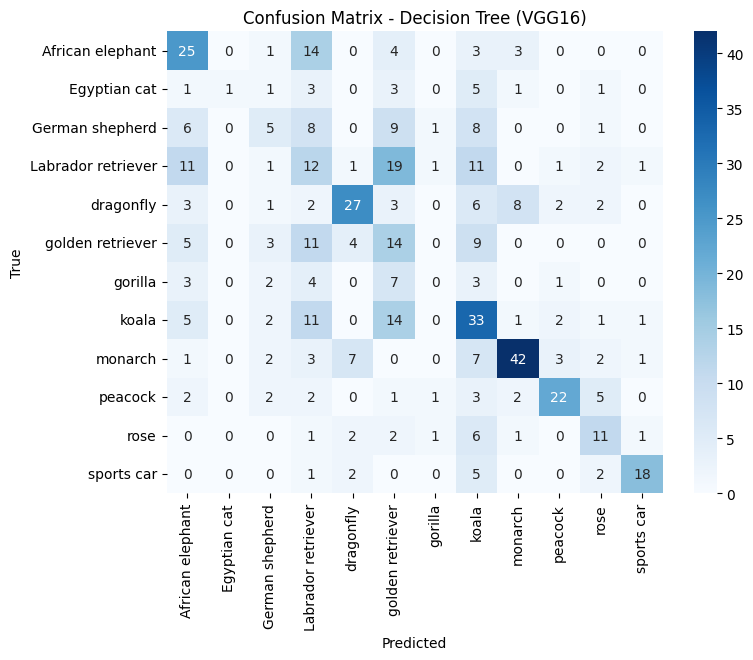

✅ Matthews Correlation Coefficient (MCC) [VGG16]: 0.3416
✅ Log Loss [VGG16]: 10.4091
ROC-AUC Score (macro, OVR) [VGG16]: 0.7404


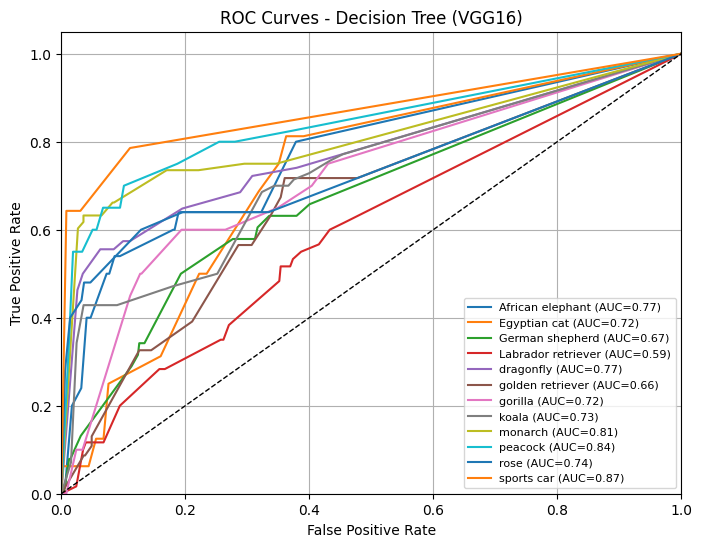


🌳 Training Decision Tree (ResNet50)...

📊 Classification Report (ResNet50):
                    precision    recall  f1-score   support

  African elephant       0.25      0.30      0.27        50
      Egyptian cat       0.00      0.00      0.00        16
   German shepherd       0.10      0.08      0.09        38
Labrador retriever       0.14      0.22      0.17        60
         dragonfly       0.30      0.26      0.28        54
  golden retriever       0.08      0.11      0.09        46
           gorilla       0.29      0.10      0.15        20
             koala       0.40      0.40      0.40        70
           monarch       0.54      0.40      0.46        68
           peacock       0.28      0.42      0.34        40
              rose       0.07      0.04      0.05        25
        sports car       0.50      0.21      0.30        28

          accuracy                           0.25       515
         macro avg       0.25      0.21      0.22       515
      weighted avg   

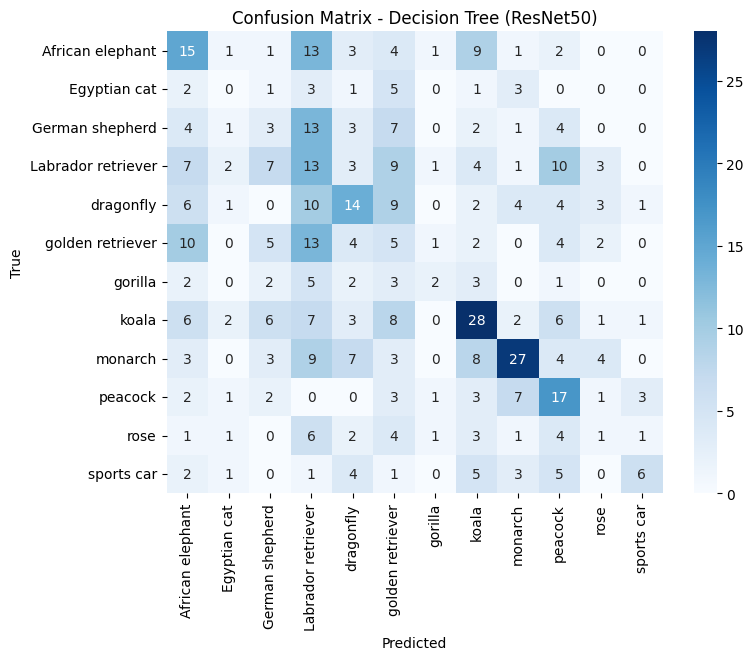

✅ Matthews Correlation Coefficient (MCC) [ResNet50]: 0.1717
✅ Log Loss [ResNet50]: 16.9971
ROC-AUC Score (macro, OVR) [ResNet50]: 0.6082


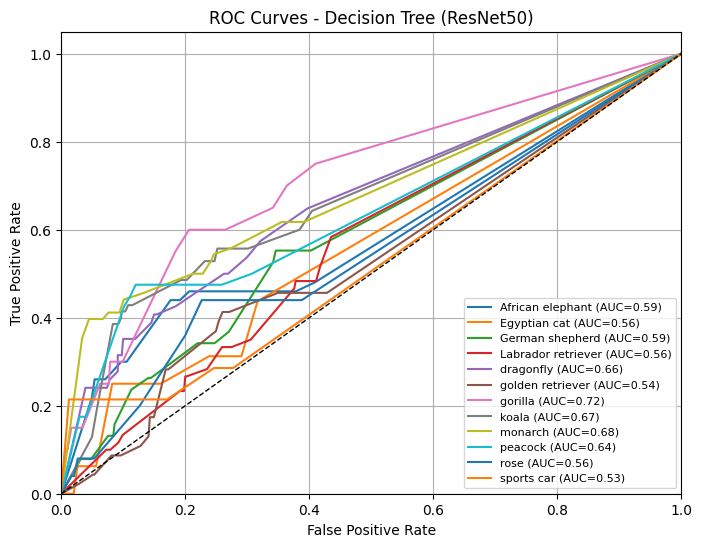

In [ ]:
# _____________________________ DECISION TREE CLASSIFIER (VGG16 + RESNET50 FEATURES) _____________________________
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
    matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# LOAD FEATURES
# -------------------------------
data = np.load("cnn_features_vgg16_resnet50.npz", allow_pickle=True)

X_train_vgg, X_test_vgg = data["X_train_vgg"], data["X_test_vgg"]
X_train_resnet, X_test_resnet = data["X_train_resnet"], data["X_test_resnet"]
y_train, y_test = data["y_train"], data["y_test"]
class_names = list(data["class_names"])

print("✅ Loaded CNN feature vectors")
print("VGG16 Train shape :", X_train_vgg.shape)
print("ResNet Train shape:", X_train_resnet.shape)

# -------------------------------
# DECISION TREE CLASSIFIER FUNCTION
# -------------------------------
def run_decision_tree(X_train, X_test, model_name, max_depth=None):
    print(f"\n🌳 Training Decision Tree ({model_name})...")

    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)

    # -------------------------------
    # EVALUATION - Basic
    # -------------------------------
    print(f"\n📊 Classification Report ({model_name}):")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - Decision Tree ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # -------------------------------
    # MCC and Log Loss
    # -------------------------------
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"✅ Matthews Correlation Coefficient (MCC) [{model_name}]: {mcc:.4f}")

    # predict_proba for log loss & ROC
    try:
        y_prob = dt.predict_proba(X_test)
    except Exception as e:
        print("⚠️ predict_proba not available:", e)
        y_prob = None

    if y_prob is not None:
        ll = log_loss(y_test, y_prob)
        print(f"✅ Log Loss [{model_name}]: {ll:.4f}")
    else:
        print("⚠️ Skipping Log Loss (no probability estimates).")

    # -------------------------------
    # ROC-AUC (One-vs-Rest)
    # -------------------------------
    if y_prob is not None:
        n_classes = len(class_names)
        y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
        try:
            auc_score = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
            print(f"ROC-AUC Score (macro, OVR) [{model_name}]: {auc_score:.4f}")
        except Exception as e:
            print("⚠️ ROC-AUC computation failed:", e)
            auc_score = None

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1.5, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves - Decision Tree ({model_name})")
        plt.legend(loc="lower right", fontsize=8)
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ Skipping ROC-AUC plots (no probability estimates).")

# -------------------------------
# RUN DECISION TREE ON BOTH FEATURE SETS
# -------------------------------
run_decision_tree(X_train_vgg, X_test_vgg, "VGG16", max_depth=10)
run_decision_tree(X_train_resnet, X_test_resnet, "ResNet50", max_depth=10)


**RF ON 2 SETS OF FEATURES [VGG16 & RESNET50]**

✅ Loaded CNN feature vectors
VGG16 Train shape : (2049, 25088)
ResNet Train shape: (2049, 100352)

🌲 Training Random Forest (VGG16)...

📊 Classification Report (VGG16):
                    precision    recall  f1-score   support

  African elephant       0.65      0.94      0.77        50
      Egyptian cat       0.00      0.00      0.00        16
   German shepherd       0.79      0.29      0.42        38
Labrador retriever       0.40      0.62      0.48        60
         dragonfly       0.87      0.85      0.86        54
  golden retriever       0.55      0.26      0.35        46
           gorilla       0.00      0.00      0.00        20
             koala       0.58      0.91      0.71        70
           monarch       0.82      0.97      0.89        68
           peacock       0.97      0.72      0.83        40
              rose       1.00      0.48      0.65        25
        sports car       1.00      1.00      1.00        28

          accuracy                           0.68

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


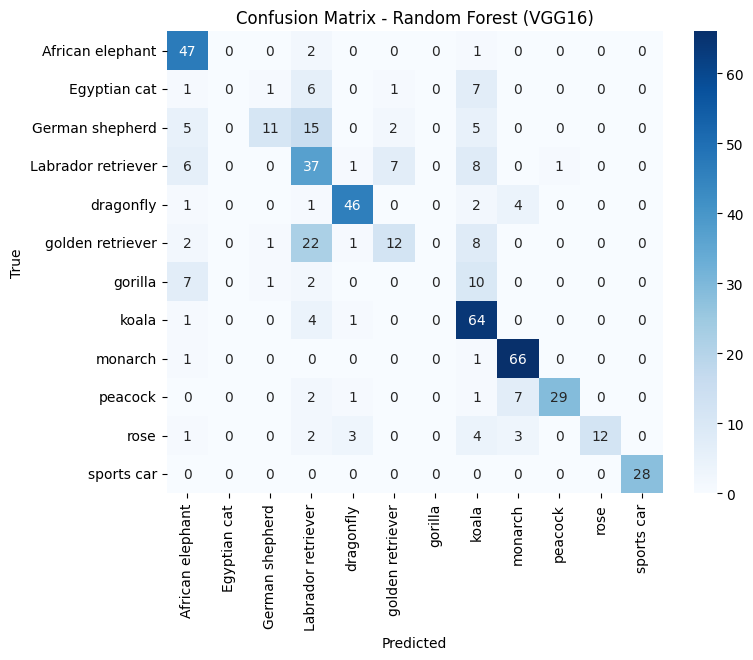

✅ Matthews Correlation Coefficient (MCC) [VGG16]: 0.6523
✅ Log Loss [VGG16]: 1.3861
ROC-AUC Score (macro, OVR) [VGG16]: 0.9389


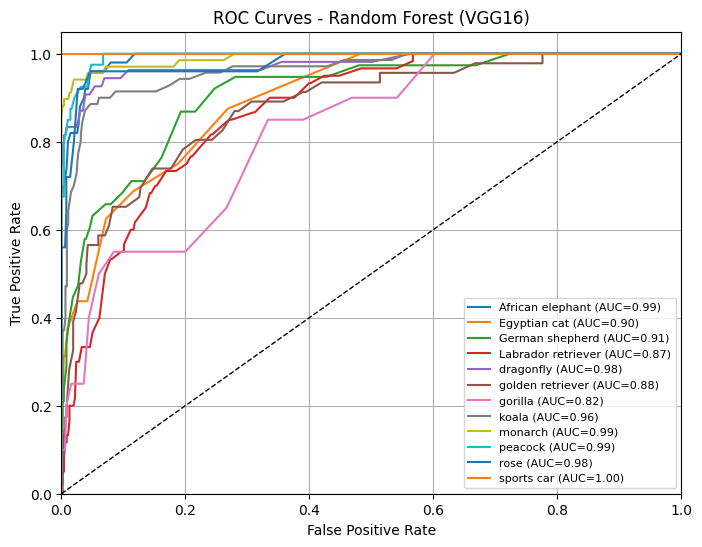


🌲 Training Random Forest (ResNet50)...

📊 Classification Report (ResNet50):
                    precision    recall  f1-score   support

  African elephant       0.51      0.62      0.56        50
      Egyptian cat       0.00      0.00      0.00        16
   German shepherd       0.20      0.05      0.08        38
Labrador retriever       0.19      0.23      0.21        60
         dragonfly       0.47      0.48      0.48        54
  golden retriever       0.22      0.30      0.26        46
           gorilla       0.00      0.00      0.00        20
             koala       0.46      0.73      0.57        70
           monarch       0.47      0.65      0.55        68
           peacock       0.60      0.45      0.51        40
              rose       0.00      0.00      0.00        25
        sports car       0.50      0.36      0.42        28

          accuracy                           0.41       515
         macro avg       0.30      0.32      0.30       515
      weighted avg   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


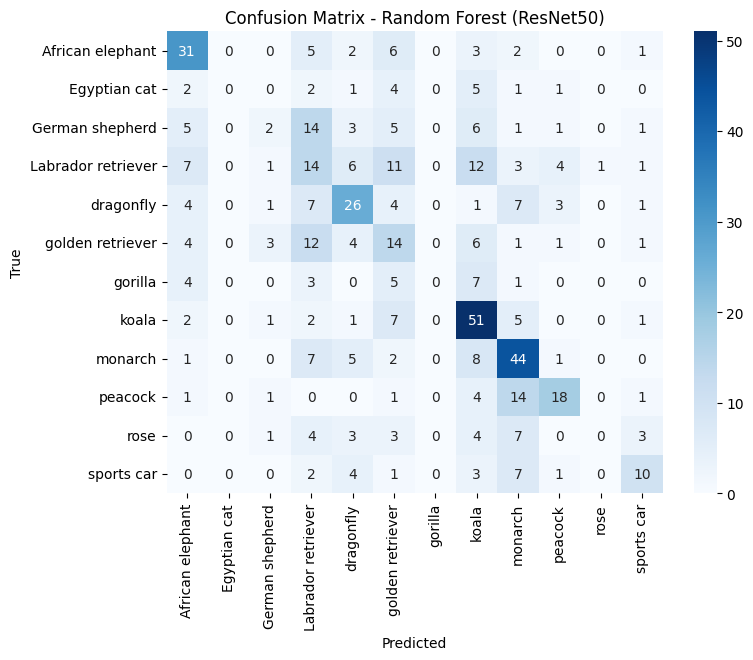

✅ Matthews Correlation Coefficient (MCC) [ResNet50]: 0.3375
✅ Log Loss [ResNet50]: 1.8635
ROC-AUC Score (macro, OVR) [ResNet50]: 0.8094


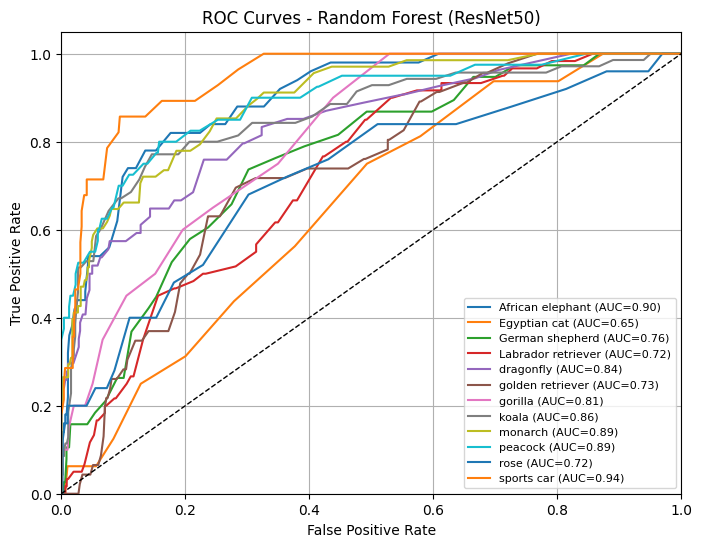

In [ ]:
# _____________________________ RANDOM FOREST CLASSIFIER (VGG16 + RESNET50 FEATURES) _____________________________
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
    matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# LOAD FEATURES
# -------------------------------
data = np.load("cnn_features_vgg16_resnet50.npz", allow_pickle=True)

X_train_vgg, X_test_vgg = data["X_train_vgg"], data["X_test_vgg"]
X_train_resnet, X_test_resnet = data["X_train_resnet"], data["X_test_resnet"]
y_train, y_test = data["y_train"], data["y_test"]
class_names = list(data["class_names"])

print("✅ Loaded CNN feature vectors")
print("VGG16 Train shape :", X_train_vgg.shape)
print("ResNet Train shape:", X_train_resnet.shape)

# -------------------------------
# RANDOM FOREST CLASSIFIER FUNCTION
# -------------------------------
def run_random_forest(X_train, X_test, model_name, n_estimators=100, max_depth=None):
    print(f"\n🌲 Training Random Forest ({model_name})...")

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    # -------------------------------
    # EVALUATION - BASIC
    # -------------------------------
    print(f"\n📊 Classification Report ({model_name}):")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - Random Forest ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # -------------------------------
    # MCC and Log Loss
    # -------------------------------
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"✅ Matthews Correlation Coefficient (MCC) [{model_name}]: {mcc:.4f}")

    y_prob = rf.predict_proba(X_test)

    ll = log_loss(y_test, y_prob)
    print(f"✅ Log Loss [{model_name}]: {ll:.4f}")

    # -------------------------------
    # ROC-AUC (One-vs-Rest)
    # -------------------------------
    n_classes = len(class_names)
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    auc_score = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    print(f"ROC-AUC Score (macro, OVR) [{model_name}]: {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1.5, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - Random Forest ({model_name})")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True)
    plt.show()

# -------------------------------
# RUN RANDOM FOREST ON BOTH FEATURE SETS
# -------------------------------
run_random_forest(X_train_vgg, X_test_vgg, "VGG16", n_estimators=200, max_depth=None)
run_random_forest(X_train_resnet, X_test_resnet, "ResNet50", n_estimators=200, max_depth=None)
